In [ ]:
# install the required dependencies
!pip install torch

!pip install torchvision

!pip install torchviz

!pip install torchsummary

!pip install tqdm

!pip install matplotlib

!pip install utils

!pip install numpy

!pip install pandas

In [2]:
'''Train CIFAR10 with PyTorch.'''
import torch

import pickle

import pandas as pd

import torchviz

import numpy as np

from torch import *

from torchvision import *

from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from torchsummary import summary

from torch.nn.utils import (
  parameters_to_vector as Params2Vec,
  vector_to_parameters as Vec2Params
)

from tqdm import tqdm


from torchvision import datasets, models
import matplotlib.pyplot as plt

from torchvision.models import *

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torch.optim.lr_scheduler import CosineAnnealingLR


In [3]:
# check if gpu is available
torch.cuda.is_available()

True

In [4]:
# Building Block Class
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.4)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        out = self.dropout(out)
        return out


# Make Layer Class
class MakeLayer(nn.Module):
    def __init__(self, block, in_planes, out_planes, blocks, stride=1):
        super(MakeLayer, self).__init__()
        self.stride = stride
        self.layer = self._make_layer(block, in_planes, out_planes, blocks, stride)

    def _make_layer(self, block, in_planes, out_planes, blocks, stride):
        layers = []
        layers.append(block(in_planes, out_planes, stride))
        if blocks > 1:
            for i in range(1, blocks):
                layers.append(block(out_planes, out_planes, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


# ResNet Class
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = MakeLayer(block, 64, 64, num_blocks[0], stride=1)
        self.layer2 = MakeLayer(block, 64, 128, num_blocks[1], stride=2)
        self.layer3 = MakeLayer(block, 128, 256, num_blocks[2], stride=2)
        # self.layer4 = MakeLayer(block, 256, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 Class
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.num_classes = num_classes
        self.resnet = ResNet(BasicBlock, [4, 3, 2], num_classes=self.num_classes)

    def forward(self, x):
        return self.resnet(x)


# Test
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ResNet18()
net.to(device)
print(net)


/state/partition1/job-45197628/ipykernel_2667656/1283630277.py:39: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for i in range(1, blocks):


ResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): MakeLayer(
      (layer): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (dropout): Dropout(p=0.4, inplace=False)
          (shortcut): Sequential()
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [5]:
# this will give us a summary of the model including the total number of parameters
summary(net, (3, 32, 32))  # Because CIFAR-10 images are 32x32x3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
           Dropout-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
          Dropout-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [6]:
# Forward pass a dummy input through the model
dummy_input = torch.randn(1, 3, 32, 32).to(device)
output = net(dummy_input)

# Visualize the model using torchviz
torchviz.make_dot(output, params=dict(net.named_parameters()))
torchviz.make_dot(output, params=dict(net.named_parameters())).render("ResNet18_Model", format="png")
#there will be a file generated called 'ResNet18_Model.png' to visualize the model as a flow
torchviz.make_dot(output, params=dict(net.named_parameters()), show_attrs=True, show_saved=True).render("ResNet18_Model1", format="png")
#there will be a file generated called 'ResNet18_Model1.png' to visualize the model as a flow

'ResNet18_Model1.png'

In [7]:
# Data Normalization and Data Augmentation
print('==> Preparing data..')
# Define additional data augmentation transforms
brightness_transforms = [
    transforms.ColorJitter(brightness=(0.75, 1.25)),
    transforms.ColorJitter(brightness=(0.5, 1.5)),
    # transforms.ColorJitter(brightness=(0.25, 0.75)),
    # transforms.ColorJitter(brightness=(0.15, 0.85))
]

contrast_transforms = [
    transforms.ColorJitter(contrast=(0.75, 1.25)),
    transforms.ColorJitter(contrast=(0.5, 1.5)),
    # transforms.ColorJitter(contrast=(0.25, 0.75)),
    # transforms.ColorJitter(contrast=(0.15, 0.85))
]

rotation_transforms = [
    transforms.RandomRotation(90),
    transforms.RandomRotation(270)  # Equivalent to -90 degrees
]

# Combine all transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply(brightness_transforms, p=0.5),
    transforms.RandomApply(contrast_transforms, p=0.5),
    transforms.RandomApply(rotation_transforms, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset with the new transformations
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=16)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=16)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified


/ext3/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 14, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Cosine Annealing Learning Rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0)

# Early stopping criteria
best_val_loss = np.inf
patience = 15  # Number of epochs to wait before early stopping
counter = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training the model
epochs = 100
print("Start training...")
for epoch in arange(epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    with tqdm(total=len(trainloader)) as pbar:
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_description(f'Epoch {epoch+1}')
            pbar.set_postfix({'Loss': running_loss / (i+1), 'Accuracy': 100. * correct / total})
            pbar.update(1)

    # Validate the model
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(testloader.dataset)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}, Accuracy: {100 * correct / total}%')

    # Update learning rate scheduler
    scheduler.step()

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping...")
            break

    # Save metrics for plotting
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100. * correct / total)
    val_losses.append(val_loss)
    val_accuracies.append(100. * correct / total)

print('Finished Training')



Start training...


Epoch 1: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s, Loss=1.78, Accuracy=31]  


Epoch 1, Validation Loss: 0.0183625962972641, Accuracy: 23.06%


Epoch 2: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s, Loss=1.63, Accuracy=38.5]


Epoch 2, Validation Loss: 0.013004295754432679, Accuracy: 39.32%


Epoch 3: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s, Loss=1.52, Accuracy=43.2]


Epoch 3, Validation Loss: 0.012063153338432312, Accuracy: 43.64%


Epoch 4: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, Loss=1.43, Accuracy=47.3]


Epoch 4, Validation Loss: 0.012745248568058015, Accuracy: 43.5%


Epoch 5: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=1.33, Accuracy=51.6]


Epoch 5, Validation Loss: 0.01111070829629898, Accuracy: 51.35%


Epoch 6: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=1.26, Accuracy=54.7]


Epoch 6, Validation Loss: 0.009799027717113495, Accuracy: 56.8%


Epoch 7: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s, Loss=1.2, Accuracy=57.1] 


Epoch 7, Validation Loss: 0.010196517157554626, Accuracy: 57.15%


Epoch 8: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, Loss=1.14, Accuracy=59.3]


Epoch 8, Validation Loss: 0.009386538475751877, Accuracy: 59.84%


Epoch 9: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s, Loss=1.09, Accuracy=61.4]


Epoch 9, Validation Loss: 0.00971892564892769, Accuracy: 59.44%


Epoch 10: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=1.05, Accuracy=62.6]


Epoch 10, Validation Loss: 0.00943878613114357, Accuracy: 60.23%


Epoch 11: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=1.02, Accuracy=64.2]


Epoch 11, Validation Loss: 0.008551766562461854, Accuracy: 62.6%


Epoch 12: 100%|██████████| 391/391 [00:30<00:00, 12.94it/s, Loss=0.987, Accuracy=65.2]


Epoch 12, Validation Loss: 0.008892432516813278, Accuracy: 63.05%


Epoch 13: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.968, Accuracy=65.9]


Epoch 13, Validation Loss: 0.0086251698076725, Accuracy: 64.19%


Epoch 14: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s, Loss=0.935, Accuracy=67.2]


Epoch 14, Validation Loss: 0.00833851922750473, Accuracy: 65.28%


Epoch 15: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s, Loss=0.919, Accuracy=67.7]


Epoch 15, Validation Loss: 0.00823978596329689, Accuracy: 66.14%


Epoch 16: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s, Loss=0.9, Accuracy=68.3]  


Epoch 16, Validation Loss: 0.006722958832979202, Accuracy: 70.91%


Epoch 17: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.882, Accuracy=69.1]


Epoch 17, Validation Loss: 0.006755239999294281, Accuracy: 70.24%


Epoch 18: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s, Loss=0.867, Accuracy=69.9]


Epoch 18, Validation Loss: 0.006803632187843323, Accuracy: 70.49%


Epoch 19: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, Loss=0.84, Accuracy=70.6] 


Epoch 19, Validation Loss: 0.006719571536779404, Accuracy: 70.93%


Epoch 20: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.834, Accuracy=70.9]


Epoch 20, Validation Loss: 0.00937495619058609, Accuracy: 61.39%


Epoch 21: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s, Loss=0.818, Accuracy=71.6]


Epoch 21, Validation Loss: 0.007533622390031814, Accuracy: 67.79%


Epoch 22: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, Loss=0.803, Accuracy=72]  


Epoch 22, Validation Loss: 0.0063322565972805025, Accuracy: 73.94%


Epoch 23: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s, Loss=0.783, Accuracy=72.9]


Epoch 23, Validation Loss: 0.005713316649198532, Accuracy: 75.1%


Epoch 24: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.781, Accuracy=72.9]


Epoch 24, Validation Loss: 0.008450896489620208, Accuracy: 66.95%


Epoch 25: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, Loss=0.765, Accuracy=73.5]


Epoch 25, Validation Loss: 0.005948801320791244, Accuracy: 74.47%


Epoch 26: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.762, Accuracy=73.4]


Epoch 26, Validation Loss: 0.007529777419567108, Accuracy: 70.47%


Epoch 27: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.752, Accuracy=73.8]


Epoch 27, Validation Loss: 0.008260821449756622, Accuracy: 67.8%


Epoch 28: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.744, Accuracy=74.2]


Epoch 28, Validation Loss: 0.005569014406204224, Accuracy: 76.7%


Epoch 29: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.733, Accuracy=74.6]


Epoch 29, Validation Loss: 0.007780629473924637, Accuracy: 68.17%


Epoch 30: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s, Loss=0.735, Accuracy=74.4]


Epoch 30, Validation Loss: 0.005697710025310517, Accuracy: 76.04%


Epoch 31: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=0.723, Accuracy=75]  


Epoch 31, Validation Loss: 0.005644833356142044, Accuracy: 75.91%


Epoch 32: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=0.712, Accuracy=75.4]


Epoch 32, Validation Loss: 0.005122828868031502, Accuracy: 78.12%


Epoch 33: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=0.706, Accuracy=75.5]


Epoch 33, Validation Loss: 0.005012573957443237, Accuracy: 78.25%


Epoch 34: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.697, Accuracy=75.9]


Epoch 34, Validation Loss: 0.0065741438031196595, Accuracy: 73.42%


Epoch 35: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.701, Accuracy=75.7]


Epoch 35, Validation Loss: 0.005368909868597984, Accuracy: 77.4%


Epoch 36: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s, Loss=0.685, Accuracy=76.3]


Epoch 36, Validation Loss: 0.00592578409910202, Accuracy: 75.49%


Epoch 37: 100%|██████████| 391/391 [00:30<00:00, 12.94it/s, Loss=0.686, Accuracy=76.2]


Epoch 37, Validation Loss: 0.005027735263109207, Accuracy: 78.36%


Epoch 38: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=0.676, Accuracy=76.6]


Epoch 38, Validation Loss: 0.004524312737584114, Accuracy: 80.12%


Epoch 39: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s, Loss=0.67, Accuracy=76.8] 


Epoch 39, Validation Loss: 0.00610177791416645, Accuracy: 74.87%


Epoch 40: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, Loss=0.662, Accuracy=77.2]


Epoch 40, Validation Loss: 0.00609395649433136, Accuracy: 75.34%


Epoch 41: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s, Loss=0.66, Accuracy=77.1] 


Epoch 41, Validation Loss: 0.00553175537288189, Accuracy: 76.76%


Epoch 42: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.647, Accuracy=77.7]


Epoch 42, Validation Loss: 0.005484706735610962, Accuracy: 77.2%


Epoch 43: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s, Loss=0.644, Accuracy=77.7]


Epoch 43, Validation Loss: 0.005788909286260605, Accuracy: 74.75%


Epoch 44: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s, Loss=0.638, Accuracy=78.1]


Epoch 44, Validation Loss: 0.006229767090082169, Accuracy: 75.26%


Epoch 45: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=0.63, Accuracy=78.1] 


Epoch 45, Validation Loss: 0.0052753635138273235, Accuracy: 77.71%


Epoch 46: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.628, Accuracy=78.4]


Epoch 46, Validation Loss: 0.005392873755097389, Accuracy: 77.54%


Epoch 47: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.619, Accuracy=78.4]


Epoch 47, Validation Loss: 0.005112288933992386, Accuracy: 78.97%


Epoch 48: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s, Loss=0.61, Accuracy=78.9] 


Epoch 48, Validation Loss: 0.004200443199276924, Accuracy: 82.32%


Epoch 49: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.604, Accuracy=79.2]


Epoch 49, Validation Loss: 0.004252043968439102, Accuracy: 82.44%


Epoch 50: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s, Loss=0.606, Accuracy=79.1]


Epoch 50, Validation Loss: 0.004582905295491218, Accuracy: 80.76%


Epoch 51: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s, Loss=0.594, Accuracy=79.4]


Epoch 51, Validation Loss: 0.004275591272115707, Accuracy: 81.56%


Epoch 52: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s, Loss=0.583, Accuracy=79.7]


Epoch 52, Validation Loss: 0.004028249207139015, Accuracy: 82.69%


Epoch 53: 100%|██████████| 391/391 [00:30<00:00, 12.95it/s, Loss=0.577, Accuracy=80.1]


Epoch 53, Validation Loss: 0.004247324576973915, Accuracy: 82.22%


Epoch 54: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, Loss=0.57, Accuracy=80.4] 


Epoch 54, Validation Loss: 0.004422564786672592, Accuracy: 81.77%


Epoch 55: 100%|██████████| 391/391 [00:30<00:00, 12.97it/s, Loss=0.568, Accuracy=80.6]


Epoch 55, Validation Loss: 0.003907086127996445, Accuracy: 83.49%


Epoch 56: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.557, Accuracy=80.9]


Epoch 56, Validation Loss: 0.004082796093821526, Accuracy: 82.84%


Epoch 57: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s, Loss=0.551, Accuracy=80.9]


Epoch 57, Validation Loss: 0.004229054179787636, Accuracy: 82.33%


Epoch 58: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s, Loss=0.539, Accuracy=81.3]


Epoch 58, Validation Loss: 0.004943236005306244, Accuracy: 79.76%


Epoch 59: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=0.543, Accuracy=81.2]


Epoch 59, Validation Loss: 0.003907341864705086, Accuracy: 83.51%


Epoch 60: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s, Loss=0.533, Accuracy=81.5]


Epoch 60, Validation Loss: 0.004735128590464592, Accuracy: 80.04%


Epoch 61: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=0.52, Accuracy=82.1] 


Epoch 61, Validation Loss: 0.0037574242293834685, Accuracy: 84.35%


Epoch 62: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=0.513, Accuracy=82.5]


Epoch 62, Validation Loss: 0.0033193089783191683, Accuracy: 86.02%


Epoch 63: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.509, Accuracy=82.3]


Epoch 63, Validation Loss: 0.004388785371184349, Accuracy: 82.43%


Epoch 64: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s, Loss=0.498, Accuracy=82.9]


Epoch 64, Validation Loss: 0.0036791865706443786, Accuracy: 84.53%


Epoch 65: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.498, Accuracy=82.8]


Epoch 65, Validation Loss: 0.0035949399530887604, Accuracy: 84.49%


Epoch 66: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s, Loss=0.486, Accuracy=83.2]


Epoch 66, Validation Loss: 0.0038938847929239273, Accuracy: 83.81%


Epoch 67: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.474, Accuracy=83.6]


Epoch 67, Validation Loss: 0.003678933298587799, Accuracy: 84.48%


Epoch 68: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.473, Accuracy=83.7]


Epoch 68, Validation Loss: 0.003118382467329502, Accuracy: 86.64%


Epoch 69: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.463, Accuracy=84.1]


Epoch 69, Validation Loss: 0.00355386051684618, Accuracy: 85.22%


Epoch 70: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s, Loss=0.447, Accuracy=84.5]


Epoch 70, Validation Loss: 0.0035580492913722993, Accuracy: 84.82%


Epoch 71: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s, Loss=0.437, Accuracy=85]  


Epoch 71, Validation Loss: 0.003234206871688366, Accuracy: 86.27%


Epoch 72: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.436, Accuracy=85]  


Epoch 72, Validation Loss: 0.003203353127837181, Accuracy: 86.6%


Epoch 73: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.428, Accuracy=85.2]


Epoch 73, Validation Loss: 0.0031739889174699784, Accuracy: 86.59%


Epoch 74: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s, Loss=0.412, Accuracy=85.7]


Epoch 74, Validation Loss: 0.0031551305338740347, Accuracy: 86.92%


Epoch 75: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s, Loss=0.399, Accuracy=86.1]


Epoch 75, Validation Loss: 0.0030227157950401306, Accuracy: 87.14%


Epoch 76: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.4, Accuracy=86.1]  


Epoch 76, Validation Loss: 0.0030982051104307177, Accuracy: 87.02%


Epoch 77: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.388, Accuracy=86.6]


Epoch 77, Validation Loss: 0.002986284963786602, Accuracy: 87.35%


Epoch 78: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, Loss=0.377, Accuracy=86.9]


Epoch 78, Validation Loss: 0.002767150607705116, Accuracy: 88.39%


Epoch 79: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s, Loss=0.369, Accuracy=87.2]


Epoch 79, Validation Loss: 0.0028092765867710114, Accuracy: 88.33%


Epoch 80: 100%|██████████| 391/391 [00:30<00:00, 12.84it/s, Loss=0.361, Accuracy=87.5]


Epoch 80, Validation Loss: 0.002663697200268507, Accuracy: 88.71%


Epoch 81: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, Loss=0.35, Accuracy=87.9] 


Epoch 81, Validation Loss: 0.0026347056955099107, Accuracy: 88.93%


Epoch 82: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s, Loss=0.337, Accuracy=88.5]


Epoch 82, Validation Loss: 0.0026631874769926073, Accuracy: 88.99%


Epoch 83: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s, Loss=0.333, Accuracy=88.4]


Epoch 83, Validation Loss: 0.002568231353163719, Accuracy: 89.5%


Epoch 84: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s, Loss=0.321, Accuracy=89]  


Epoch 84, Validation Loss: 0.002337557406723499, Accuracy: 89.92%


Epoch 85: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s, Loss=0.318, Accuracy=88.9]


Epoch 85, Validation Loss: 0.0024512444123625755, Accuracy: 89.59%


Epoch 86: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=0.304, Accuracy=89.4]


Epoch 86, Validation Loss: 0.002302789957076311, Accuracy: 90.3%


Epoch 87: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.293, Accuracy=89.9]


Epoch 87, Validation Loss: 0.0022931343466043473, Accuracy: 90.47%


Epoch 88: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.286, Accuracy=90.1]


Epoch 88, Validation Loss: 0.0023017627432942393, Accuracy: 90.5%


Epoch 89: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.279, Accuracy=90.3]


Epoch 89, Validation Loss: 0.0022242696598172187, Accuracy: 90.9%


Epoch 90: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, Loss=0.271, Accuracy=90.5]


Epoch 90, Validation Loss: 0.002176103051006794, Accuracy: 90.98%


Epoch 91: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s, Loss=0.26, Accuracy=91]   


Epoch 91, Validation Loss: 0.0020932704649865626, Accuracy: 91.13%


Epoch 92: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, Loss=0.257, Accuracy=91.1]


Epoch 92, Validation Loss: 0.0020941466152668, Accuracy: 91.19%


Epoch 93: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=0.249, Accuracy=91.4]


Epoch 93, Validation Loss: 0.002130064119398594, Accuracy: 91.3%


Epoch 94: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s, Loss=0.247, Accuracy=91.3]


Epoch 94, Validation Loss: 0.002074956476688385, Accuracy: 91.37%


Epoch 95: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, Loss=0.239, Accuracy=91.7]


Epoch 95, Validation Loss: 0.0020440831676125527, Accuracy: 91.63%


Epoch 96: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s, Loss=0.237, Accuracy=91.9]


Epoch 96, Validation Loss: 0.0020796706423163412, Accuracy: 91.35%


Epoch 97: 100%|██████████| 391/391 [00:30<00:00, 12.94it/s, Loss=0.234, Accuracy=91.9]


Epoch 97, Validation Loss: 0.002053239314258099, Accuracy: 91.56%


Epoch 98: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s, Loss=0.235, Accuracy=91.9]


Epoch 98, Validation Loss: 0.0020148021563887596, Accuracy: 91.7%


Epoch 99: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, Loss=0.231, Accuracy=92.1]


Epoch 99, Validation Loss: 0.0020270916163921356, Accuracy: 91.72%


Epoch 100: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, Loss=0.231, Accuracy=91.9]


Epoch 100, Validation Loss: 0.0020555901199579237, Accuracy: 91.52%
Finished Training


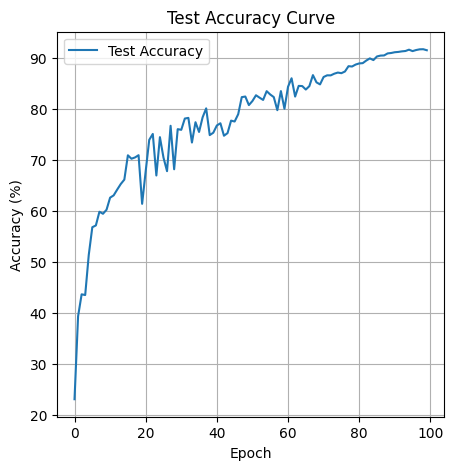

In [9]:
# Plot train and test accuracy
plt.figure(figsize=(5, 5))
# plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()



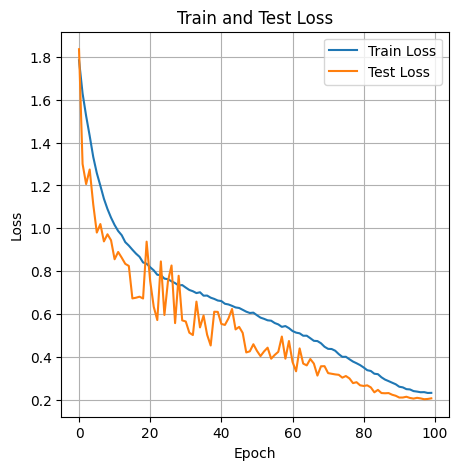

In [10]:
# Plot train and test loss
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot([loss * 100 for loss in val_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
torch.save(net.state_dict(), 'ResNet_modified')

In [14]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [15]:
testdata = unpickle('cifar_test_nolabels.pkl')

In [16]:
# Define the dataset class for custom test dataset
class CustomTestDataset(Dataset):
    def __init__(self, data_file, transform=None):
        with open(data_file, 'rb') as f:
            data = pickle.load(f, encoding='bytes')
        self.images = data[b'data']
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(3, 32, 32).transpose(1, 2, 0)  # Reshape image
        if self.transform:
            image = self.transform(image)
        return idx, image

# Define the transformations similar to CIFAR-10
transform_test_custom = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [17]:
# custom_testset = CustomTestDataset(testdata, transform=transform_test_custom)
# print( len(custom_testset))

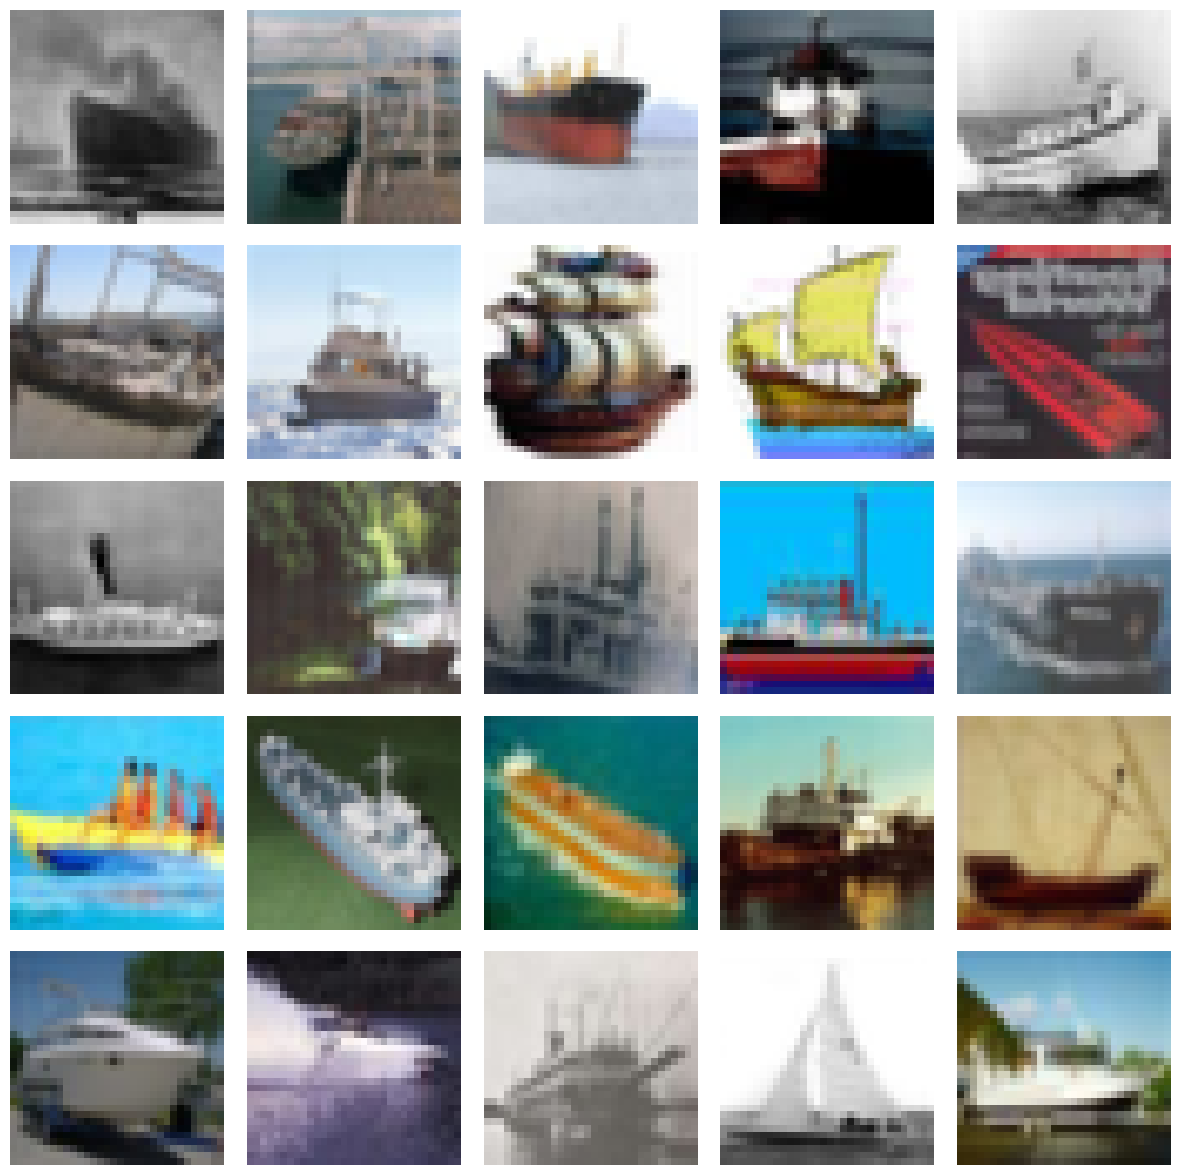

In [18]:
def visualize_dataset(dataset, num_images=25, num_cols=5, image_size=(3, 32, 32), figsize=(15, 15)):
    data = dataset[b'data']
    num_rows = num_images // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i in arange(num_images):
        row = i // num_cols
        col = i % num_cols
        img = data[i].reshape(*image_size)  # Reshape image data
        img = np.transpose(img, (1, 2, 0))  # Convert from (channel, height, width) to (height, width, channel)
        axes[row, col].imshow(img)
        axes[row, col].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Assuming 'testdata' is the test dataset dictionary
visualize_dataset(testdata, num_images=25, num_cols=5, figsize=(15, 15))


In [19]:
# Load the model
# model = models.resnet18(pretrained=False)  # Assuming you trained your model similar to ResNet-18
# # Load the trained weights
# model.load_state_dict(torch.load('path_to_your_trained_model.pth'))
net.eval()
net = net.to(device)
# images.to(device)

# Load custom test dataset
custom_test_dataset = CustomTestDataset('cifar_test_nolabels.pkl', transform=transform_test_custom)
testloader_custom = DataLoader(custom_test_dataset, batch_size=100, shuffle=False, num_workers=16)

# Make predictions
predictions = []
with torch.no_grad():
    for idx, images in testloader_custom:
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().tolist())

# Generate CSV file with IDs and labels
with open('predictions_modified.csv', 'w') as f:
    f.write('ID,Labels\n')
    for idx, label in enumerate(predictions):
        f.write(f'{idx},{label}\n')